# Correlations

---

## Overview

Now that I have some perspective, I can actually dive in here and get the data into a meaningful, and useful format.
Ultimately the goal is to create a `DataFrame`, that can of course be written to a `.csv` file; or of course a series of `DataFrame`'s could be written to a `.xlsx` file.


## Setup


### Working Directory

This just helps with using local imports from the larger project to the notebook.

In [1]:
cd ../

/Users/chrismessier/work/behaviorally


### Imports

In [2]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from numpy import random as rng
from matplotlib import pyplot as plt
from google.protobuf.struct_pb2 import Struct
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2

import processors
import tools

#### Plotting Config

In [3]:
%matplotlib inline
sns.set(
    style='darkgrid'
)

In [4]:
from config import ONS_ANALYSIS_JOB_NUMBERS  # Job Numbers of interest for this

## Analysis

### Background

Now that I have all of the information that I need for this analysis, I can finally string things together in a sensible manner; cleaning up was I had initially done in the [project-forensics.ipynb](./project-forensics.ipynb) file.

### Spreadsheets

These will be needed later...

In [5]:
doc_1 = '/Users/chrismessier/work/behaviorally/data/Behaviorally - Report 4.18.22[8].xlsx'
doc_2 = '/Users/chrismessier/work/behaviorally/data/IRI Data Product List_3.21.22.xlsx'
doc_3 = '/Users/chrismessier/work/behaviorally/data/ONS Validation_dcs_processed_v1.3.xlsx'

This is the doc that has all of Tony's results.
The first step: narrow this down to only the items of interest for the client (`ONS_ANALYSIS_JOB_NUMBERS`). 

In [6]:
doc_4 = '/Users/chrismessier/work/behaviorally/data/ONS_output_Tony_Round 1.xlsx'

> Alot of the processing here is copied from [project-forensics.ipynb](notebooks/project-forensics.ipynb).
> Check there for thorough explanations.

This here `df` dataframe will be my working data throughout this notebook.

In [7]:
target_sheet = 'ONS_output_Tony'

df = pd.read_excel(doc_4, sheet_name=target_sheet)
df['job_number'] = df['Image Name'].apply(lambda s: s.split('_')[0].strip())  # retrieving the first item of the concatenated Image Name


Focus only on our items of interest.

In [8]:
df = df[df['job_number'].isin(ONS_ANALYSIS_JOB_NUMBERS)].copy() # .copy() ensures we're using a deepcopy

Now we need the UPC codes.

In [9]:
iri_data = pd.read_excel(doc_2, sheet_name='50 products')
iri_data.dropna(axis=0, how='all', inplace=True)
iri_data.dropna(subset=['UPC'], how='all', inplace=True)

In [10]:
iri_data.head(2)

,JobNumber,Category,Product description,Variant,SKU #,UPC
1,AB238.00,ALCOHOLIC BEV - Beer,Cass Fresh Individual Beer,355mL can and 500mL bottle,NaN,1002334
2,AC156.00,ALCOHOLIC BEV - Beer,"Lagunitas IPA Beer , 6pk/ 12 fl oz bottles","IPA, Hazy Wonder IPA, DayTime IPA",NaN,723830000094


In [11]:
iri_data['job_number'] = iri_data['JobNumber'].apply(lambda s: s.split('.')[0])

In [12]:
iri_data.drop_duplicates(subset=['job_number'], inplace=True)

I just thought of this: I haven't checked to see if any of the iri data is missing!
I may have really fucked things up here...

In [13]:
for x in ONS_ANALYSIS_JOB_NUMBERS:
    y = x in iri_data['job_number'].values.tolist()
    if not y:
        print(x, y)

PHEW!

Still, now I can reduce the IRI dataframe to only the job numbers of interest as well.

In [14]:
iri_data = iri_data[iri_data['job_number'].isin(ONS_ANALYSIS_JOB_NUMBERS)].copy() # .copy() ensures we're using a deepcopy

In [15]:
iri_data.shape

(51, 7)

Why are there four extra rows...?
There are only 51 JobNumbers of interest, but there are 55 rows here.

In [16]:
from collections import defaultdict

d = defaultdict(list)

for i, row in iri_data.iterrows():
    d[row['job_number']].append(row['UPC'])


issue_keys = []

for k, v in d.items():
    if len(v) > 1:
        print(k, v)
        issue_keys.append(k)

In [17]:
iri_data[iri_data['job_number'].isin(issue_keys)]

,JobNumber,Category,Product description,Variant,SKU #,UPC,job_number


In [18]:
# iri_data.dropna(subset=['UPC'], how='all', inplace=True)

I was having a lot of problems with the `'UPC'` duplicate, and the problem was some errant whitespace in one of the values.
I just swapped to `'job_number'` instead: that's what it's there for.

In [19]:
# iri_data.drop_duplicates(subset=['job_number'], inplace=True)

In [20]:
iri_data.head(2)

,JobNumber,Category,Product description,Variant,SKU #,UPC,job_number
6,AD905.00,ALCOHOLIC BEV - Beer,"Keystone Light Lager Beer, 15-pack, 12oz cans",NaN,NaN,71990281519,AD905
15,AD112.00,ALCOHOLIC BEV - Hard Liquors,Remy Martin Club Cognac 700ml,NaN,NaN,3024480008797,AD112


Now that this table is all cleaned-up, I can map it back to the primary working data in `df` and continue on down the road of analysis.

In [21]:
df.head()

,Image Name,Image ID,Raw ONS Line and Pack,job_number
33,AB031_LINE1.jpg,LINE1,42.0,AB031
34,AB031_LINE2.jpg,LINE2,48.0,AB031
35,AB031_LINE3.jpg,LINE3,42.0,AB031
36,AB031_LINE4.jpg,LINE4,40.0,AB031
82,AB111_LINE1.jpg,LINE1,45.0,AB111


In [22]:
df.loc[:, 'upc'] = None

In [23]:
for i, row in iri_data.iterrows():
    job_number = row['job_number']
    upc = row['UPC']
    df.loc[df['job_number'] == job_number, 'upc'] = upc

In [24]:
df

,Image Name,Image ID,Raw ONS Line and Pack,job_number,upc
33,AB031_LINE1.jpg,LINE1,42.0,AB031,12000012754
34,AB031_LINE2.jpg,LINE2,48.0,AB031,12000012754
35,AB031_LINE3.jpg,LINE3,42.0,AB031,12000012754
36,AB031_LINE4.jpg,LINE4,40.0,AB031,12000012754
82,AB111_LINE1.jpg,LINE1,45.0,AB111,70462035964
...,...,...,...,...,...
4714,L2362_LINE3.jpg,LINE3,39.0,L2362,87692006602
4737,L2403_LINE1.jpg,LINE1,27.0,L2403,7020054430
4738,L2403_LINE2.jpg,LINE2,44.0,L2403,7020054430
4739,L2403_LINE3.jpg,LINE3,44.0,L2403,7020054430


### UPC Mapping

This is where I have to figure out how the UPC mapping will be finalized.
I'm thinking that I'll just repurpose what was done in [items-of-interest.ipynb](notebooks/items-of-interest.ipynb) again.

In [25]:
rng.seed(42)

In [26]:
report = processors.sample_behaviorally_reports(doc_1)

In [27]:
report_number = report['REPORT'].unique()

In [28]:
report = report.infer_objects()

There were complaints about an outlier value skewing the representational value of the plots.
After reviewing the data, it's pretty obvious that Coca-Cola is the offender, with $18M in weekly sales, there's no wonder it's throwing things off.
As a rough buffer against that, I'm just gonna go ahead and drop the row with the largest `'Dollar Sales'` value.  

In [29]:
report = report.drop(report['Dollar Sales'].idxmax())

In [30]:
report.shape

(45, 16)

In [31]:
report.head(2)

,Product,Dollar Sales,Dollar Sales % Change vs YA,Unit Sales,Unit Sales % Change vs YA,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,UPC 10 digit,Category Name,Sub-Category Name,Brand Name,REPORT
7,PEPSI COLA SODA REGULAR CALORIES PLASTIC BOTTL...,1.053024e+07,0.073827,5.530233e+06,0.041584,2.374186,2.045063,3.260978,2.830028,1.904122,0.030956,1200000129,CARBONATED BEVERAGES,REGULAR SOFT DRINKS,PEPSI,103
8,PEPSI COLA SODA REGULAR CALORIES PLASTIC BOTTL...,1.916534e+02,1.445339,9.538572e+01,1.534032,0.000041,0.000014,0.000056,0.000020,2.009246,-0.035001,2000001291,CARBONATED BEVERAGES,REGULAR SOFT DRINKS,PEPSI,103


In [32]:
from fuzzywuzzy import process


def __get_upc_mappings(a, b, threshold=75):
    """ 2 dfs -> upc mappings
    """
    d = {}

    for i, row in a.iterrows():  # each row will correspond to an item. need to look up UPC 10 digit
        upc = row['UPC 10 digit']
        match, score = process.extractOne(upc, b['upc'].values)
        
        if score >= threshold:
            # d[upc] = match   # I had these mixed up...
            d[match] = upc

    return d   


In [33]:
d = __get_upc_mappings(report, df)

In [34]:
import tools

upc_to_ten, ten_to_upc = tools.get_upc_mappings(report, df)

In [35]:
len(upc_to_ten.keys())

41

In [36]:
df.head(2)

,Image Name,Image ID,Raw ONS Line and Pack,job_number,upc
33,AB031_LINE1.jpg,LINE1,42.0,AB031,12000012754
34,AB031_LINE2.jpg,LINE2,48.0,AB031,12000012754


In [37]:
df['upc_10'] = df['upc'].apply(lambda k: upc_to_ten.get(k, None))

In [38]:
df.head()

,Image Name,Image ID,Raw ONS Line and Pack,job_number,upc,upc_10
33,AB031_LINE1.jpg,LINE1,42.0,AB031,12000012754,1200001275
34,AB031_LINE2.jpg,LINE2,48.0,AB031,12000012754,1200001275
35,AB031_LINE3.jpg,LINE3,42.0,AB031,12000012754,1200001275
36,AB031_LINE4.jpg,LINE4,40.0,AB031,12000012754,1200001275
82,AB111_LINE1.jpg,LINE1,45.0,AB111,70462035964,0462035964


In [39]:
df['UPC 10 digit'] = df['upc_10'].copy()  # HACK this is super-stoopid. You need to brush up on pandas, dummy.

In [40]:
df.head()

,Image Name,Image ID,Raw ONS Line and Pack,job_number,upc,upc_10,UPC 10 digit
33,AB031_LINE1.jpg,LINE1,42.0,AB031,12000012754,1200001275,1200001275
34,AB031_LINE2.jpg,LINE2,48.0,AB031,12000012754,1200001275,1200001275
35,AB031_LINE3.jpg,LINE3,42.0,AB031,12000012754,1200001275,1200001275
36,AB031_LINE4.jpg,LINE4,40.0,AB031,12000012754,1200001275,1200001275
82,AB111_LINE1.jpg,LINE1,45.0,AB111,70462035964,0462035964,0462035964


In [41]:
df_ = df.merge(report, how='left', on='UPC 10 digit')

Surprisingly, this actually looks good! 

In [42]:
df_.sample(1)

,Image Name,Image ID,Raw ONS Line and Pack,job_number,upc,upc_10,UPC 10 digit,Product,Dollar Sales,Dollar Sales % Change vs YA,...,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,Category Name,Sub-Category Name,Brand Name,REPORT
224,AD445_PACK2.jpg,PACK2,14.0,AD445,22200954419,2220095441,2220095441,MENNEN LADY SPEED STICK INVISIBLE DRY ANTIPERS...,41869.335142,-0.708961,...,0.148267,0.316656,0.148267,0.316656,2.164863,-0.091645,DEODORANT,DEODORANTS,MENNEN LADY SPEED STICK INVISIBLE DRY,103


In [43]:
# report = processors.sample_behaviorally_reports(doc_1)
# report = report.drop(report['Dollar Sales'].idxmax())

Here I must discuss one of our foundational decisions for this model.
For this data, we're ignoring any temporal effects, largely because we don't really have great insights into the times a particular image was displayed.
Given this, here I am going to drop the `"REPORT"` column, as that's what provided at least the sequence of the observations.
Instead, we are to treat them as independent.   

In [44]:
# reports.drop(axis=1, labels='REPORT', inplace=True) 
# reports.head()

### Correlations

Now we get to the ultimate question: What are we correlating?

> ONS vs. ???

Obviously the "independent" variable will be the ONS scores, and I believe the "dependent" variable will be the the "Dollar Sales".
I believe the results will need to be aggregated in order to make any sense, seeing as we have multiple variations on sales 


#### Aggregation

In [45]:
# reports = processors.behaviorally_reports(doc_1)
# reports_agg = reports.groupby('UPC 10 digit')['Dollar Sales'].mean()
# reports_agg = reports.groupby('UPC 10 digit').mean()

# reports_agg

##### ONS Scores

Here I am going to get the mean ONS score by item first, as this is the easiest way to look into this.

In [46]:
df_.head(2)

,Image Name,Image ID,Raw ONS Line and Pack,job_number,upc,upc_10,UPC 10 digit,Product,Dollar Sales,Dollar Sales % Change vs YA,...,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,Category Name,Sub-Category Name,Brand Name,REPORT
0,AB031_LINE1.jpg,LINE1,42.0,AB031,12000012754,1200001275,1200001275,LIPTON CITRUS GREEN TEA LIQUID PREPARED TEA PL...,637651.530263,-0.00381,...,0.688945,0.679966,1.092425,0.994317,1.614852,0.005614,TEA/COFFEE - READY-TO-DRINK,CANNED AND BOTTLED TEA,LIPTON,103
1,AB031_LINE2.jpg,LINE2,48.0,AB031,12000012754,1200001275,1200001275,LIPTON CITRUS GREEN TEA LIQUID PREPARED TEA PL...,637651.530263,-0.00381,...,0.688945,0.679966,1.092425,0.994317,1.614852,0.005614,TEA/COFFEE - READY-TO-DRINK,CANNED AND BOTTLED TEA,LIPTON,103


I'm kind of just taking a stab here...

#### Main Plotting Loop

The first thing I'm going to do is go across all of the reports.

In [47]:
reports = processors.behaviorally_reports(doc_1, as_dicts=True)  # TODO fix this name, 'as_dicts' makes no sense 

# sneak sneak
# reports = [processors.behaviorally_reports(doc_1)]  # HACK just so I can also get the "totals" as well

OUTPUT_DIR = "/Users/chrismessier/work/behaviorally/outputs"

OVERWRITE = False


corr_coefs = []  # dist across all relations

corr_coefs = defaultdict(list)

frmt = lambda s: '-'.join(s.upper().split()).replace('%', 'PCT')


pbar = tqdm(enumerate(reports, start=1), total=len(reports))  # HACK using their own report-numbering scheme against them!

all_dfs = []


for i, report in pbar:  
    df_ = df.merge(report, how='left', on='UPC 10 digit')
    df_ = df_.infer_objects()  # this here attempts to coerce objects to floats, leaving the strings untouched.
    results_agg = df_.groupby('job_number').mean()

    all_dfs.append(df_)

    x, *columns = results_agg.columns

    for c in columns:
        
        ro = results_agg[x].corr(results_agg[c])  # NOTE I believe this is returning a null-value, so need to dig into this more.
        title = f"Report ${i}$\n{x} vs. {c}\n$R={ro:.3f}$"

        image_name = f"{i}_{frmt(x)}_v_{frmt(c)}.png"

        save_dir = os.path.join(OUTPUT_DIR, 'reports', f'report_{i}')

        os.makedirs(save_dir, exist_ok=True)

        output_path = os.path.join(save_dir, image_name)

        if not os.path.exists(output_path) or OVERWRITE:

            plt.title(title)
            plt.scatter(results_agg[x], results_agg[c])
            plt.xlabel(x)
            plt.xlim((0, 100))
            plt.ylabel(c)
            plt.tight_layout()
            # plt.show()

            plt.savefig(output_path)

            plt.clf()  # clear canvas for reuse

        corr_coefs[i].append(ro)


  0%|          | 0/156 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

In [48]:
DF = pd.concat(all_dfs)

Now to super charge it:

#### Distribution of Correlation Coefficients

Looking now across all of the correlation coefs:

In [62]:
import tools.plotting  # went ahead and moved the plotting func here


all_coefs = []

l = list(corr_coefs.items())

pbar = tqdm(l)

for (k, v) in pbar:
    _ = tools.plotting.coef_dist_plot(v, tag=str(k))  # HACK because k is coming in as an int
    for x in v:
        all_coefs.append(x)

tools.plotting.coef_dist_plot(all_coefs)

  0%|          | 0/156 [00:00<?, ?it/s]

In [ ]:
sns.displot()

array([-0.11662538])

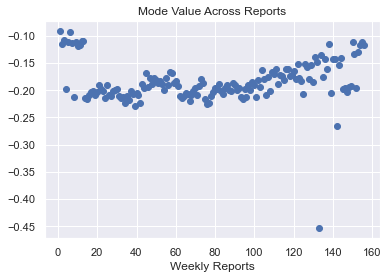

In [71]:
import scipy

ks = []
vs = []

for k, v in corr_coefs.items():
    ks.append(k)
    vs.append(scipy.stats.mode(v).mode[0])

plt.scatter(ks, vs)
plt.title('Mode Value Across Reports')
plt.xlabel('Weekly Reports')
plt.savefig('outputs/analysis/modes.png')

### Tuesday, April 26th

Understanding the data better will require looking into the conditional distributions of the correlations coefficients.
As in, what is the difference in the distributions of the coefficients between different products, product categories, sub categories, or between pack/line images. Really, any other way to subdivide the data should be explored.

Normalize `"Dollar Sales"` by sampling for a specific product across periods.

It would be good to see these correlation plots by product.

In [50]:
df_.head()

,Image Name,Image ID,Raw ONS Line and Pack,job_number,upc,upc_10,UPC 10 digit,Product,Dollar Sales,Dollar Sales % Change vs YA,...,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,Category Name,Sub-Category Name,Brand Name,REPORT
0,AB031_LINE1.jpg,LINE1,42.0,AB031,12000012754,1200001275,1200001275,LIPTON CITRUS GREEN TEA LIQUID PREPARED TEA PL...,559818.372886,-0.129208,...,0.634297,0.687771,1.023347,1.11394,1.688259,0.044037,TEA/COFFEE - READY-TO-DRINK,CANNED AND BOTTLED TEA,LIPTON,156
1,AB031_LINE2.jpg,LINE2,48.0,AB031,12000012754,1200001275,1200001275,LIPTON CITRUS GREEN TEA LIQUID PREPARED TEA PL...,559818.372886,-0.129208,...,0.634297,0.687771,1.023347,1.11394,1.688259,0.044037,TEA/COFFEE - READY-TO-DRINK,CANNED AND BOTTLED TEA,LIPTON,156
2,AB031_LINE3.jpg,LINE3,42.0,AB031,12000012754,1200001275,1200001275,LIPTON CITRUS GREEN TEA LIQUID PREPARED TEA PL...,559818.372886,-0.129208,...,0.634297,0.687771,1.023347,1.11394,1.688259,0.044037,TEA/COFFEE - READY-TO-DRINK,CANNED AND BOTTLED TEA,LIPTON,156
3,AB031_LINE4.jpg,LINE4,40.0,AB031,12000012754,1200001275,1200001275,LIPTON CITRUS GREEN TEA LIQUID PREPARED TEA PL...,559818.372886,-0.129208,...,0.634297,0.687771,1.023347,1.11394,1.688259,0.044037,TEA/COFFEE - READY-TO-DRINK,CANNED AND BOTTLED TEA,LIPTON,156
4,AB111_LINE1.jpg,LINE1,45.0,AB111,70462035964,0462035964,0462035964,SOUR PATCH KIDS ASSORTED SOUR CHEWY CANDY PIEC...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NON-CHOCOLATE CANDY,NON CHOCOLATE CHEWY CANDY,SOUR PATCH KIDS,156


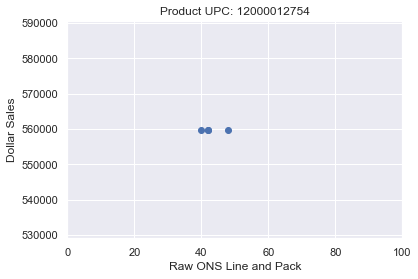

In [51]:
x_col = 'Raw ONS Line and Pack'

for upc in df_['upc'].unique():
    df__ = df_.loc[df_['upc'] == upc, :]


    plt.title(f"Product UPC: {upc}")
    plt.xlabel('Raw ONS Line and Pack')
    plt.ylabel('Dollar Sales')
    plt.scatter(df__[x_col], df__['Dollar Sales'])
    plt.xlim((0, 100))
    plt.show() 
    break

In [52]:
df.shape

(352, 7)

In [53]:
df_.describe(include='all')

,Image Name,Image ID,Raw ONS Line and Pack,job_number,upc,upc_10,UPC 10 digit,Product,Dollar Sales,Dollar Sales % Change vs YA,...,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,Category Name,Sub-Category Name,Brand Name,REPORT
count,358,358,358.000000,358,358,318,318,318,2.760000e+02,276.000000,...,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,318,318,318,318
unique,352,56,NaN,50,50,41,41,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,37,39,41,1
top,AD216_PACK3.jpg,LINE1,NaN,AD324,300672039248,0067203924,0067203924,EXCEDRIN MIGRAINE ACETMPHEN/ASPIRIN EXTRA STRE...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,FOOD & TRASH BAGS,ADULT INTERNAL ANALGESICS,EXCEDRIN MIGRAINE,156
freq,2,38,NaN,18,18,18,18,18,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18,18,18,318
mean,NaN,NaN,45.667598,NaN,NaN,NaN,NaN,NaN,5.752580e+05,1.993625,...,0.819157,0.822572,2.284151,2.299381,6.474707,0.114153,NaN,NaN,NaN,NaN
std,NaN,NaN,24.798654,NaN,NaN,NaN,NaN,NaN,6.902461e+05,16.746749,...,2.197396,2.098864,5.195900,5.117805,4.021096,0.165332,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,3.399497e+01,-0.999605,...,0.000018,0.000053,0.000023,0.000073,1.195454,-0.258934,NaN,NaN,NaN,NaN
25%,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,NaN,9.782403e+04,-0.203306,...,0.065237,0.065243,0.154082,0.130703,3.496861,0.024476,NaN,NaN,NaN,NaN
50%,NaN,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,2.520924e+05,-0.050232,...,0.240828,0.187252,0.549024,0.487925,5.412488,0.088287,NaN,NaN,NaN,NaN
75%,NaN,NaN,70.000000,NaN,NaN,NaN,NaN,NaN,8.510316e+05,0.186942,...,0.583336,0.689523,1.329114,1.698544,7.952598,0.168099,NaN,NaN,NaN,NaN


In [54]:
DF.shape

(55848, 22)

In [55]:
DF.to_csv('data/behaviorally_merged_sales_data.csv')

In [56]:
DF.columns

Index(['Image Name', 'Image ID', 'Raw ONS Line and Pack', 'job_number', 'upc',
       'upc_10', 'UPC 10 digit', 'Product', 'Dollar Sales',
       'Dollar Sales % Change vs YA', 'Unit Sales',
       'Unit Sales % Change vs YA', 'Unit Share of Category',
       'Unit Share of Category Year Ago', 'Unit Share of SubCategory',
       'Unit Share of SubCategory Year Ago', 'Price per Unit',
       'Price per Unit % Change vs YA', 'Category Name', 'Sub-Category Name',
       'Brand Name', 'REPORT'],
      dtype='object')

In [57]:
DF.head()

,Image Name,Image ID,Raw ONS Line and Pack,job_number,upc,upc_10,UPC 10 digit,Product,Dollar Sales,Dollar Sales % Change vs YA,...,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,Category Name,Sub-Category Name,Brand Name,REPORT
0,AB031_LINE1.jpg,LINE1,42.0,AB031,12000012754,1200001275,1200001275,LIPTON CITRUS GREEN TEA LIQUID PREPARED TEA PL...,754888.359249,-0.015202,...,0.835315,0.906572,1.230062,1.303955,1.603665,0.101032,TEA/COFFEE - READY-TO-DRINK,CANNED AND BOTTLED TEA,LIPTON,1
1,AB031_LINE2.jpg,LINE2,48.0,AB031,12000012754,1200001275,1200001275,LIPTON CITRUS GREEN TEA LIQUID PREPARED TEA PL...,754888.359249,-0.015202,...,0.835315,0.906572,1.230062,1.303955,1.603665,0.101032,TEA/COFFEE - READY-TO-DRINK,CANNED AND BOTTLED TEA,LIPTON,1
2,AB031_LINE3.jpg,LINE3,42.0,AB031,12000012754,1200001275,1200001275,LIPTON CITRUS GREEN TEA LIQUID PREPARED TEA PL...,754888.359249,-0.015202,...,0.835315,0.906572,1.230062,1.303955,1.603665,0.101032,TEA/COFFEE - READY-TO-DRINK,CANNED AND BOTTLED TEA,LIPTON,1
3,AB031_LINE4.jpg,LINE4,40.0,AB031,12000012754,1200001275,1200001275,LIPTON CITRUS GREEN TEA LIQUID PREPARED TEA PL...,754888.359249,-0.015202,...,0.835315,0.906572,1.230062,1.303955,1.603665,0.101032,TEA/COFFEE - READY-TO-DRINK,CANNED AND BOTTLED TEA,LIPTON,1
4,AB111_LINE1.jpg,LINE1,45.0,AB111,70462035964,0462035964,0462035964,SOUR PATCH KIDS ASSORTED SOUR CHEWY CANDY PIEC...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NON-CHOCOLATE CANDY,NON CHOCOLATE CHEWY CANDY,SOUR PATCH KIDS,1
